In [1]:
from collections import defaultdict

import time 
import random
import numpy as np

import torch
import torch.nn as nn

In [4]:
gpu_id = "2"

In [5]:
device = torch.device("cuda:" + gpu_id if torch.cuda.is_available() else "cpu")

In [8]:
torch.cuda.memory_allocated()

0

In [46]:
word2index = defaultdict(lambda : len(word2index))
tag2index = defaultdict(lambda : len(tag2index))

In [47]:
def read_data(data_path, sep):
    
    with open(data_path) as f:
        
        data = f.read().split("\n")
        
        for line in data:
            tmp = line.lower().strip().split(sep)
            
            if len(tmp) != 2:
                continue
            
            tag, sentence = tmp
            yield ([word2index[word] for word in sentence.split()], tag2index[tag])

In [48]:
train_data = list(read_data("../../cmu_data/classes/train.txt", " ||| "))

In [51]:
UNK = word2index["unk"]

In [52]:
len(train_data), len(word2index)

(8544, 16580)

In [53]:
word2index = defaultdict(lambda : UNK, word2index)

In [54]:
dev = list(read_data("../../cmu_data/classes/test.txt", " ||| "))

In [56]:
tag2index

defaultdict(<function __main__.<lambda>()>,
            {'3': 0, '4': 1, '2': 2, '1': 3, '0': 4})

In [57]:
vocab_size = len(word2index)
tag_size = len(tag2index)

In [17]:
class BasicModel(nn.Module):
    
    def __init__(self, vocab_size, tag_size):
        
        super(BasicModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, tag_size)
        self.b = nn.Parameter(torch.zeros(size=(tag_size, )))
        
    
    def forward(self, inputs):
        
        # inputs: (input_length, )
        
        inputs = self.embedding(inputs) # (input_length, tag_size)
        inputs = torch.sum(inputs, dim=0) # (tag_size, )
        outputs = inputs + self.b # (tag_size, )
        
        outputs = torch.unsqueeze(outputs, dim=0) # (1, tag_size)
        return outputs

In [66]:
test_tmp = torch.randn(size=(2, 3))

In [67]:
test_id = torch.argmax(test_tmp, dim=1)

In [68]:
test_id

tensor([0, 1])

In [73]:
test_tmp[:, test_id]

tensor([[ 2.2257,  0.7270],
        [-0.7519,  0.0926]])

In [71]:
test_tmp

tensor([[ 2.2257,  0.7270, -1.4132],
        [-0.7519,  0.0926, -0.0769]])

In [74]:
test_tmp = np.random.randn(2, 3)

In [75]:
test_id = np.argmax(test_tmp, axis=1)

In [80]:
test_tmp[[0, 1], test_id]

array([1.88198468, 1.27670283])

In [81]:
test_tmp[:, test_id]

array([[1.88198468, 1.88198468],
       [1.27670283, 1.27670283]])

In [84]:
test_tmp[np.arange(test_tmp.ndim), test_id]

array([1.88198468, 1.27670283])

In [90]:
EPOCH = 50

In [91]:
net = BasicModel(vocab_size, tag_size).to(device)

In [92]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
loss_trace = []
acc_trace = []

In [93]:
for epoch in range(EPOCH):
    
    random.shuffle(train_data)
    
    train_loss = 0.0
    start_time = time.time()
    
    for sent, tag in train_data:
        
        sent = torch.tensor(sent).to(device)
        tag = torch.tensor([tag]).to(device)
        
        output = net(sent)
        loss = criterion(output, tag)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_trace.append(train_loss / len(train_data))
    
    print("Epoch: {}, time: {}, loss: {}".format(epoch, time.time() - start_time, train_loss / len(train_data)))
    
    correct_num = 0
    
    with torch.no_grad():
        
        for sent, tag in dev:
            
            sent = torch.tensor(sent).to(device)
            
            output = net(sent)
            
            pred_id = torch.argmax(output, dim=1)
            
            if pred_id[0] == tag:
                correct_num += 1
    
    print("Epoch: {}, acc: {}".format(epoch, correct_num / len(dev)))
    
    acc_trace.append(correct_num / len(dev))

Epoch: 0, time: 13.438459873199463, loss: 4.2323214290027025
Epoch: 0, acc: 0.267420814479638
Epoch: 1, time: 12.216273784637451, loss: 3.2354667585609964
Epoch: 1, acc: 0.2828054298642534
Epoch: 2, time: 12.59132719039917, loss: 2.6072510319795943
Epoch: 2, acc: 0.2981900452488688
Epoch: 3, time: 13.714014291763306, loss: 2.1634173640832635
Epoch: 3, acc: 0.3036199095022624
Epoch: 4, time: 12.726889848709106, loss: 1.8265127337285691
Epoch: 4, acc: 0.30995475113122173
Epoch: 5, time: 12.731423139572144, loss: 1.561475701436635
Epoch: 5, acc: 0.3171945701357466
Epoch: 6, time: 12.265281677246094, loss: 1.3480246700850065
Epoch: 6, acc: 0.31131221719457014
Epoch: 7, time: 11.142706871032715, loss: 1.173356274129236
Epoch: 7, acc: 0.3217194570135747
Epoch: 8, time: 15.682672023773193, loss: 1.02896311318337
Epoch: 8, acc: 0.3257918552036199
Epoch: 9, time: 15.773892641067505, loss: 0.9089722383716898
Epoch: 9, acc: 0.3384615384615385
Epoch: 10, time: 12.670617818832397, loss: 0.808302894

In [94]:
import matplotlib.pyplot as plt

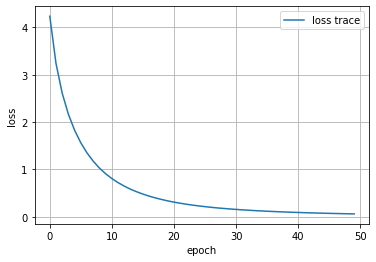

In [95]:
plt.plot(loss_trace, label="loss trace")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()

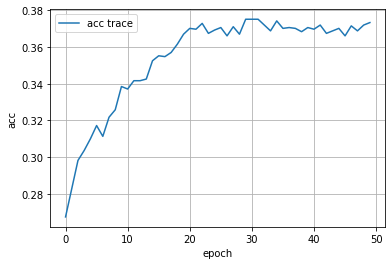

In [96]:
plt.plot(acc_trace, label="acc trace")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.grid()
plt.legend()